# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In [45]:
#Importing all necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [46]:
#Import data
df = pd.read_csv('recipe_site_traffic_2212.csv')

In [47]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


# Data validation

### The origianl data had 947 rows and 8 columns. After validation, there are 895 rows remaining. The following describes what was done to each column:
- Recipe: All values are unique and have a correct data type (int), as expected.
- Calories: 52 rows had missing values and were dropped. Type of data (float) was as expected.
- Carbohydrate: 52 rows (same rows as calories) had missing values and were dropped. Type of data (float) was as expected.
- Sugar: 52 rows (same rows as calories) had missing values and were dropped. Type of data (float) was as expected.
- Protein: 52 rows (same rows as calories) had missing values and were dropped. Type of data (float) was as expected.
- Category: Column had 11 categories instead of expected 10. Chicken Breast and Chicken categories were merged under Chicken. Data type was changed to categorical.
- Servings: 3 rows included strings instead of expected integers only. Integers were extracted and data type was changed to int.
- High_traffic: Missing values were filled in with "Low". They were mapped to True (High) and False (Low) values. Type changed to boolean.

In [48]:
#Initial exploration
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [49]:
#Validate unique recipe ids
df['recipe'].nunique()

947

In [50]:
#Where calories is missing, carbs, sugar and protein is missing too. Rows were therefore dropped.
df[df['calories'].isna()].isna().sum()

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic    13
dtype: int64

In [51]:
#Validate category
print(df['category'].unique(), '\n')

#Chicken Breast and Chicken merged, converted to categorical
df['category'] = df['category'].str.replace('Chicken Breast', 'Chicken')
df['category'] = pd.Categorical(df['category'])

#Validate category after transformation
print(df['category'].unique())

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert'] 

['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert']
Categories (10, object): ['Beverages', 'Breakfast', 'Chicken', 'Dessert', ..., 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']


In [52]:
#Validate servings
print(df['servings'].unique(), '\n')

#Extracted the numbers and converted to integers
df['servings'] = df['servings'].str.extract(r'(\d+)', expand=False).astype(int)

#Validate servings after transformation
print(df['servings'].unique())

['6' '4' '1' '2' '4 as a snack' '6 as a snack'] 

[6 4 1 2]


In [53]:
#Validate high_traffic
print(df['high_traffic'].value_counts(), '\n')

#Missing values filled with low_traffic and converted to categorical
df['high_traffic'] = df['high_traffic'].fillna(value='Low')
df['high_traffic'] = df['high_traffic'].map({'High': True, 'Low': False})

#Validate high_traffic after transformation
print(df['high_traffic'].value_counts())

High    574
Name: high_traffic, dtype: int64 

True     574
False    373
Name: high_traffic, dtype: int64


In [54]:
#Missing values where dropped
df.dropna(inplace=True)

In [55]:
#Data Validation - final check
df.info()

#No missing values and all columns have correct types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 1 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        895 non-null    int64   
 1   calories      895 non-null    float64 
 2   carbohydrate  895 non-null    float64 
 3   sugar         895 non-null    float64 
 4   protein       895 non-null    float64 
 5   category      895 non-null    category
 6   servings      895 non-null    int64   
 7   high_traffic  895 non-null    bool    
dtypes: bool(1), category(1), float64(4), int64(2)
memory usage: 51.1 KB


# EDA

### I have investigated the target variable (High Traffic) and detailes of recipes, and the relationship between the target variable and the details. After the analysis, I decided to apply the following changes:
- Create

**Target Variable - High Traffic**

Since we need to predict if the recipe will result in high traffic, the high traffic variable would be our target variable. From the count plot below, we can see that majority of the recipes featured on the homepage resulted in high traffic.

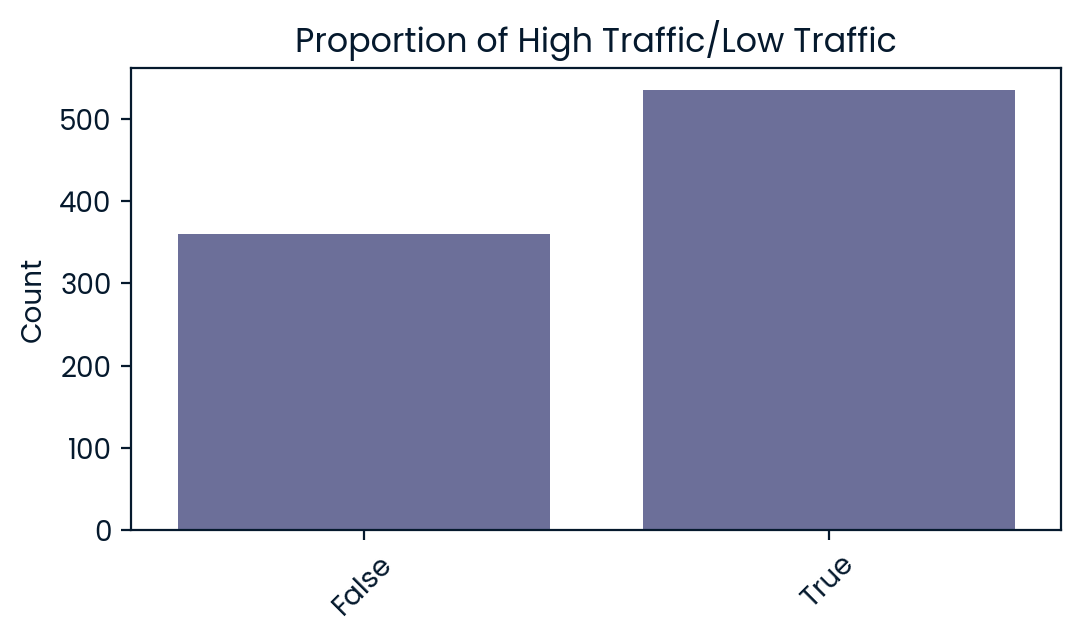

In [56]:
plt.figure(figsize=(6, 3))
sns.countplot(data=df, x='high_traffic')
plt.title('Proportion of High Traffic/Low Traffic')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Single Variable (Recipe Details - Category)

Chicken is the most frequently featured category of recipe on the homepage, followed by Breakfast and Beverages.

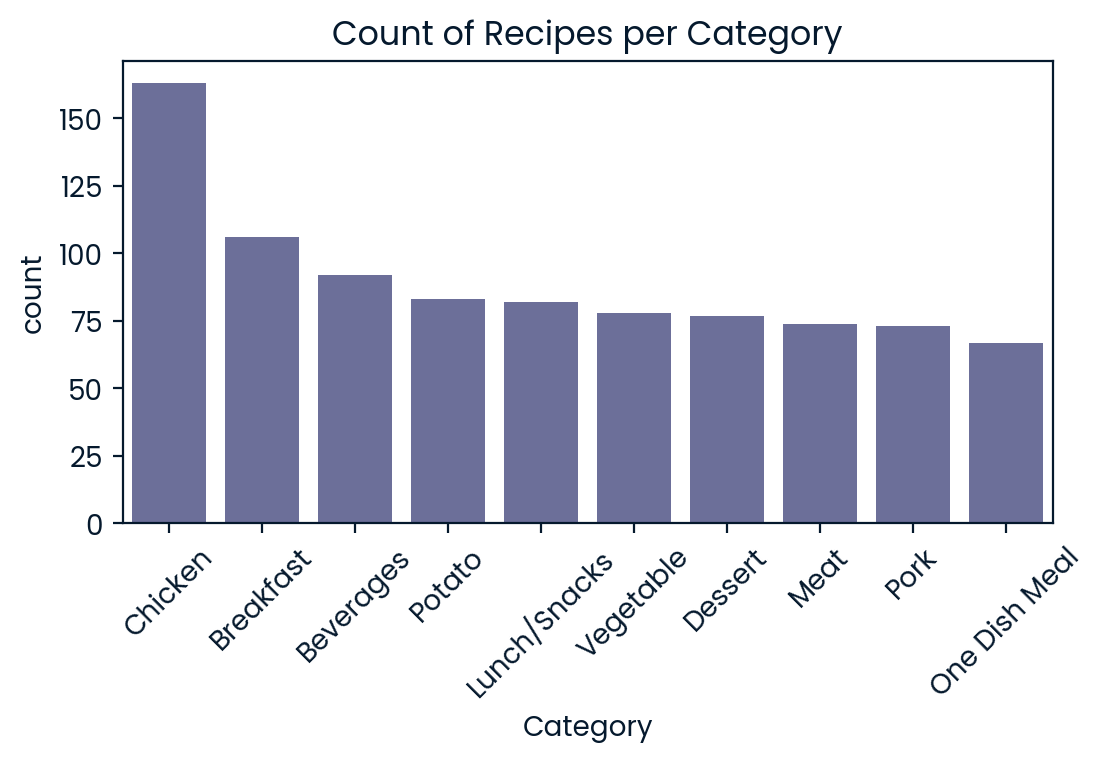

In [57]:
plt.figure(figsize=(6, 3))
sns.countplot(data=df, x='category', order=df['category'].value_counts(ascending=False).index)
plt.title('Count of Recipes per Category')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.show()

### Multivariable (Proportin of High Traffic Recipes by Category)

From previous visualisation we learned that, Chicken is the most frequently featured category and that majority of recipes featured result in high traffic. Analysing the relationship between category of recipe and whether it results in high traffic, we can learn that the three most featured categories (Chicken, Breakfast & Beverages) usually do not result in high traffic. The categories which are featured slightly less frequently (Vegetable, Potato & Pork) have a much higher proportion of high traffic.

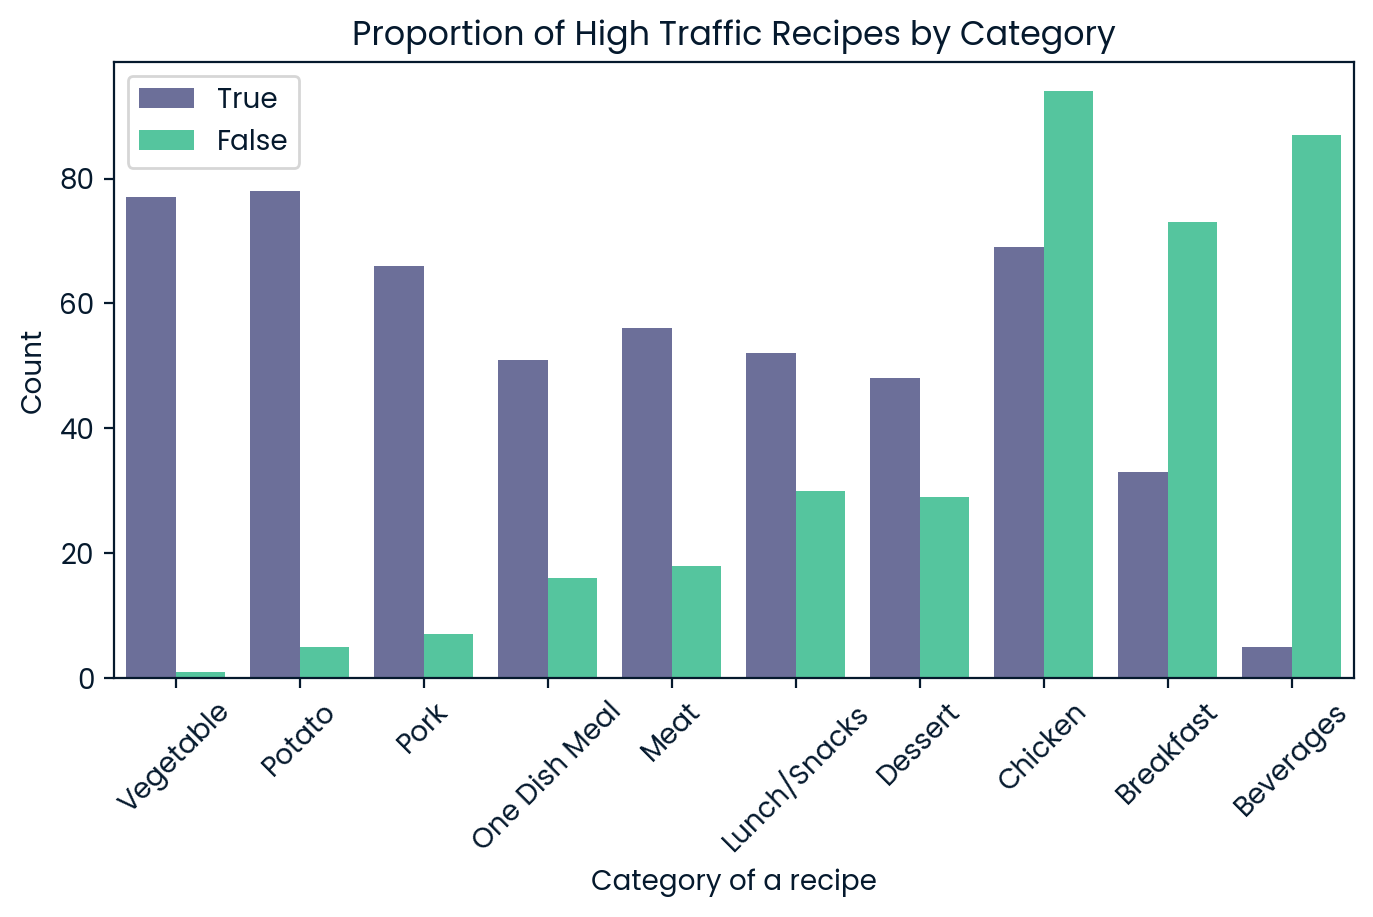

In [58]:
# Calculate the percentage of high-traffic recipes per category
high_traffic_percentage = df[df['high_traffic'] == 'High'].groupby('category').size() / df.groupby('category').size()

# Sort categories by high-traffic percentage
sorted_categories = high_traffic_percentage.sort_values(ascending=True).index

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='category', hue='high_traffic', order=sorted_categories[::-1], hue_order=[True, False])
plt.title('Proportion of High Traffic Recipes by Category')
plt.xlabel('Category of a recipe')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.legend()
plt.show()

# Model Development

Predicting if featuring the recipe on the homepage will result in high traffic is a binary classification problem. I am choosing the Logistic Regression model, because we will be predicting the categorical variable of high traffic. The comparison model I am choosing is the Random Forest Classifier.

For the evaluation, I am choosing the accuracy score and classification report.

### Prepare Data for Modeling

In [59]:
#Function to print metrics of the models

def print_metrics(y_test, y_pred):
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {precision:.3f}")
    print(f"Accuracy: {accuracy:.3f}", '\n')

    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

In [60]:
#Prepare data for modeling

df = df.drop('recipe', axis=1)

X = df.drop('high_traffic', axis=1)
y = df['high_traffic']

X = pd.get_dummies(X, columns=['category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [61]:
lr = LogisticRegression(max_iter=200)

lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr.predict(X_test)

print_metrics(y_test, y_pred_lr)

Precision: 0.816
Accuracy: 0.773 

Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.73      0.72       108
        True       0.82      0.80      0.81       161

    accuracy                           0.77       269
   macro avg       0.76      0.77      0.77       269
weighted avg       0.77      0.77      0.77       269

Confusion Matrix:
[[ 79  29]
 [ 32 129]]


In [62]:
dtc = DecisionTreeClassifier(random_state=1)

dtc.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dtc = dtc.predict(X_test)

print_metrics(y_test, y_pred_dtc)

Precision: 0.764
Accuracy: 0.691 

Classification Report:
              precision    recall  f1-score   support

       False       0.60      0.68      0.64       108
        True       0.76      0.70      0.73       161

    accuracy                           0.69       269
   macro avg       0.68      0.69      0.68       269
weighted avg       0.70      0.69      0.69       269

Confusion Matrix:
[[ 73  35]
 [ 48 113]]


# Model Evaluation

Baseline model (Logistic Regression) performs better, than the Decision Tree Classifier model. The goal of this notebook is to predict recipes resulting in high traffic 80% of the time. Considering that the model evaluation metric I chose is precision. The cost of classifing the recipe as high traffic incorrectly is high for the business, therefore it is the most important metric. Logistic Regression model scores 0.816 which is higher, than the goal of 80% which would be 0.8 in the metric. Out of the two models tested the logistic regreesion performs much better.

In [63]:
print(f"Precision (Logistic Regression): {precision_score(y_test, y_pred_lr):.3f}", '\n')
print(f"Precision (Decision Tree Classifier): {precision_score(y_test, y_pred_dtc):.3f}")

Precision (Logistic Regression): 0.816 

Precision (Decision Tree Classifier): 0.764


# Business Metrics

### KPI we will use to compare the model to the business will be the proportion of true positives to false positives. We will divide the number of true positives by false positives to get the KPI. Result equal to or greater than 4.0, indicates that the model is perfoming as expected.

The goal is to predict the high traffic recipe 80% of the time. Using an example, if we predict 100 recipes, and the least amount we need to predict correctly to consider the model successful is 80, and assume the rest where false positives (predicted as high traffic, in reality resulting in low traffic). 80/20 = 4. Therefore, we are aming for KPI to stay at or above 4.0.

From the KPIs below we can clearly see that the Logistic Regression model with the score of 4.45 performs much better, than Decision Tree Classifier.

Confusion Matrix (Logistic Regression):
[[ 79  29]
 [ 32 129]]
KPI (Logistic Regression): 4.45 

Confusion Matrix (Decision Tree Classifier):
[[ 73  35]
 [ 48 113]]
KPI (Decision Tree Classifier): 3.23


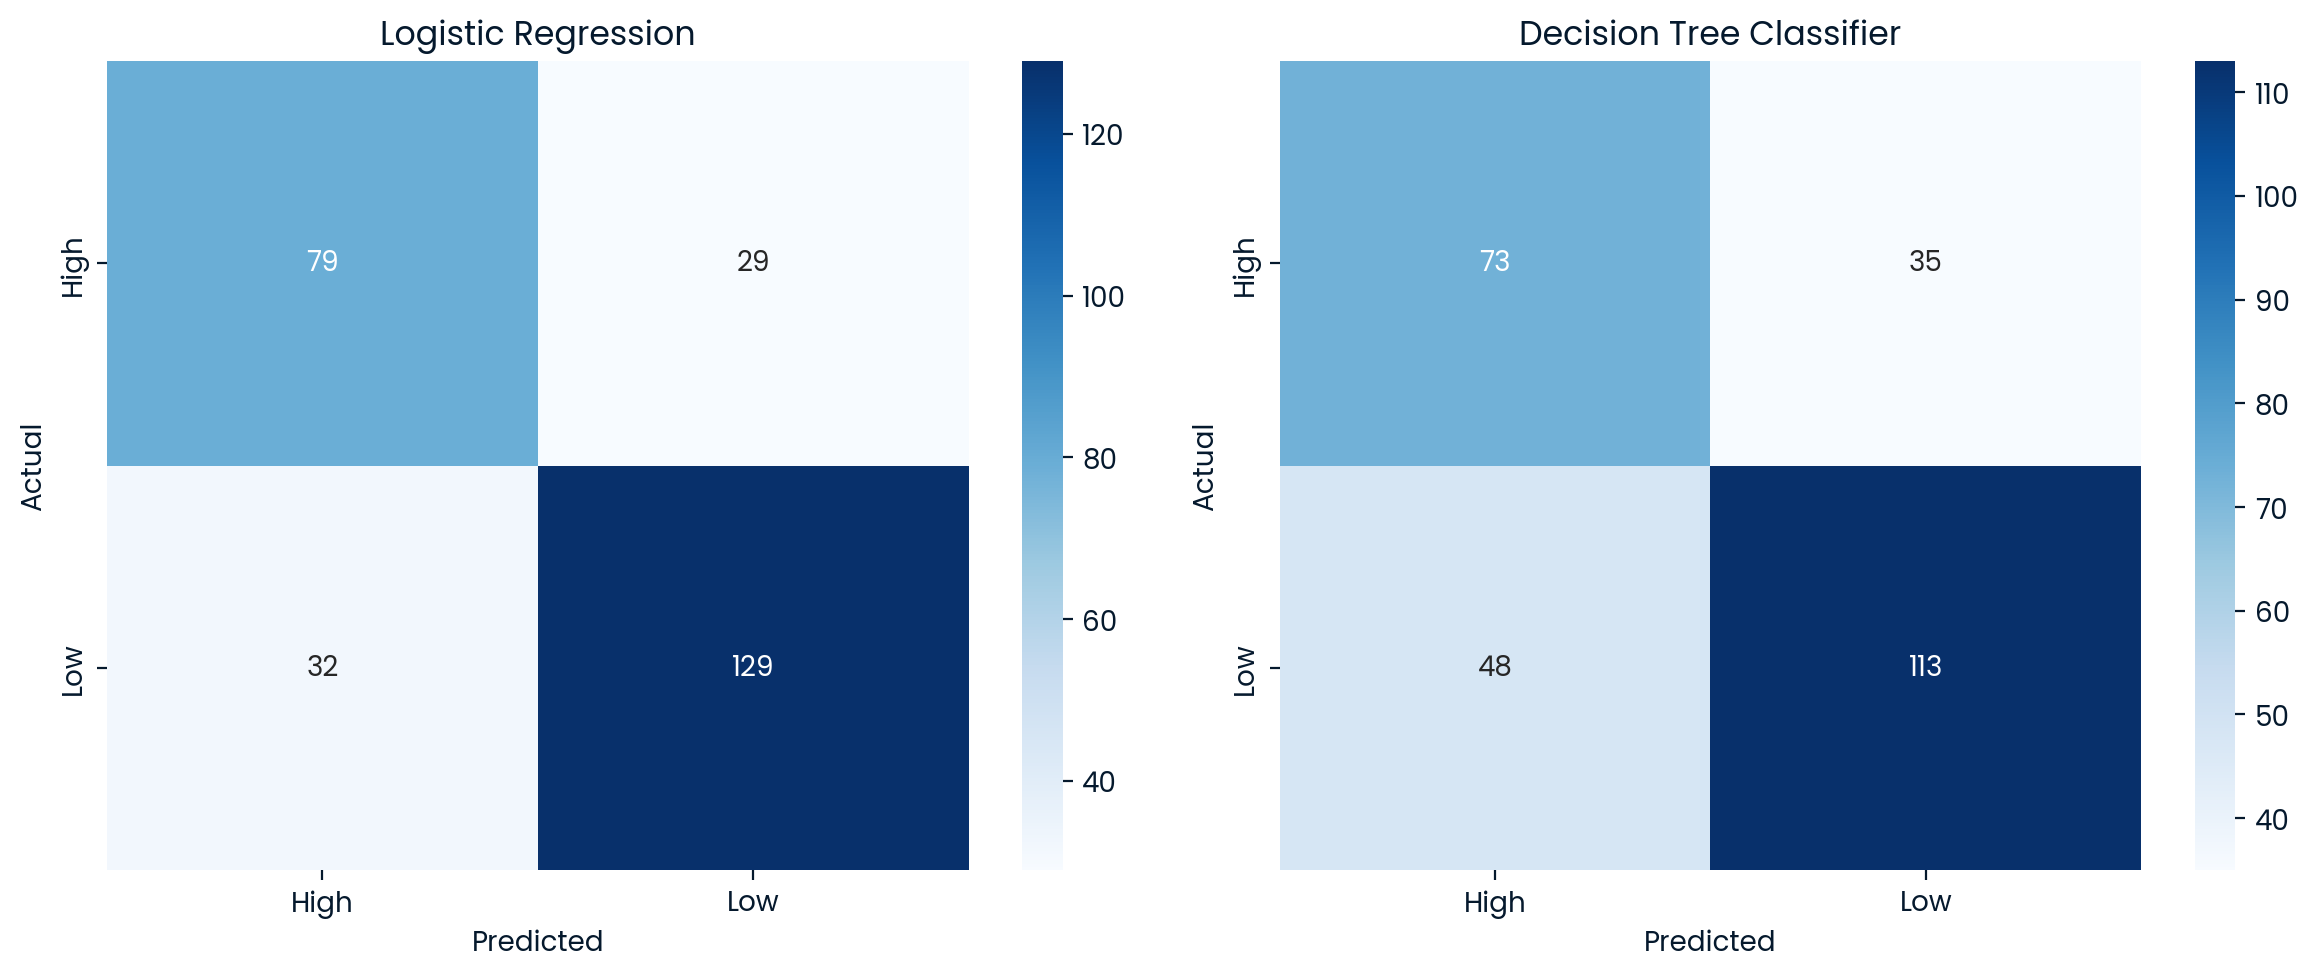

In [64]:
# Calculate confusion matrices
lr_confusion_matrix = confusion_matrix(y_test, y_pred_lr)
dtc_confusion_matrix = confusion_matrix(y_test, y_pred_dtc)

kpi_lr = (lr_confusion_matrix[1, 1] / lr_confusion_matrix[0, 1]).round(2)
kpi_dtc = (dtc_confusion_matrix[1, 1] / dtc_confusion_matrix[0, 1]).round(2)

# Print confusion matrices and KPI
print("Confusion Matrix (Logistic Regression):")
print(lr_confusion_matrix)
print(f"KPI (Logistic Regression): {kpi_lr}", '\n')

print("Confusion Matrix (Decision Tree Classifier):")
print(dtc_confusion_matrix)
print(f"KPI (Decision Tree Classifier): {kpi_dtc}")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the Logistic Regression confusion matrix
sns.heatmap(lr_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['High', 'Low'], yticklabels=['High', 'Low'], ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the Decision Tree Classifier confusion matrix
sns.heatmap(dtc_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['High', 'Low'], yticklabels=['High', 'Low'], ax=axes[1])
axes[1].set_title('Decision Tree Classifier')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Adjust layout
plt.tight_layout()
plt.show()

# KPI Visualisation

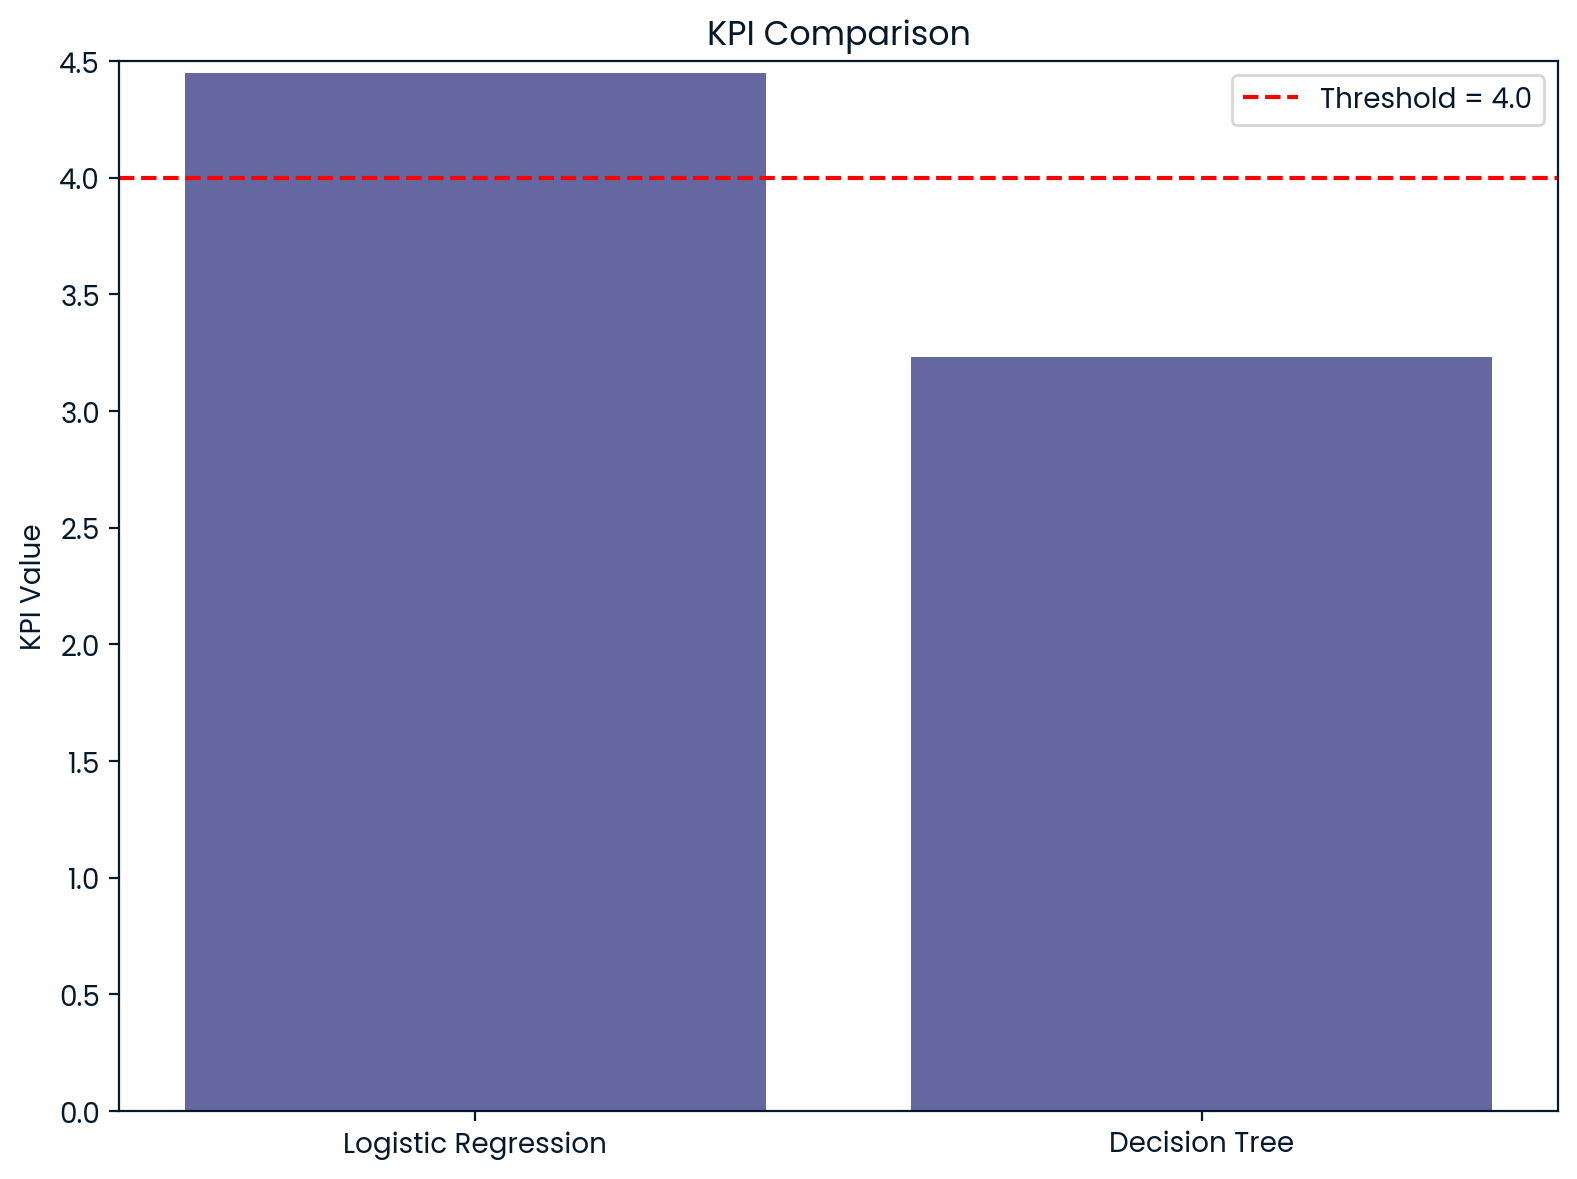

In [65]:
plt.figure(figsize=(8, 6))
plt.bar(['Logistic Regression', 'Decision Tree'], [kpi_lr, kpi_dtc])
plt.ylim(0, max(kpi_lr, kpi_dtc, 4.5))
plt.axhline(y=4.0, color='red', linestyle='--', label='Threshold = 4.0')
plt.title('KPI Comparison')
plt.ylabel('KPI Value')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation